# C++ Convolution

This note shows:
1. C++ code from Python
2. Convolution in C++
3. C++ Convolution from Python

## C/C++ from Python

The easy part:  
To create a C/C++ function from a library file, you add 'extern "C"' to the function header.  
The difficult part:  
Passing parameters and returning values.

## grab image

#### from previous notebook  
http://localhost:8888/notebooks/1_Image_Metadata.ipynb

In [26]:
def image_meta(image_file):
    from PIL import Image
    height = !identify -format '%h' {image_file}
    height = int(height[0])
    width = !identify -format '%w' {image_file}
    width = int(width[0])
    has_alpha_channel = !identify -format '%A' {image_file}
    has_alpha_channel = has_alpha_channel[0]
    channel_cnt = 3
    if has_alpha_channel:
        channel_cnt = 4
    # only 3 channels, red, green, blue, no alpha
    channel_size = width * height
    
    pixels = list(Image.open(image_file).getdata())
    red = list()
    green = list()
    blue = list()
    # will discard alpha channel
    for quadruple in pixels:
        red.append(quadruple[0])
        green.append(quadruple[1])
        blue.append(quadruple[2])
    
    return [height, width, red, green, blue]  

def display_channel(pixels, width):
    from PIL import Image
    height = (int) (len(pixels)/width)
    img = Image.new('L', (width, height))
    img.putdata(pixels)
    display(img)

In [27]:
image_file = './imgs/green_911_turbo_86.jpeg'
[height, width, red,green,blue] = image_meta(image_file)
channel_size = height * width

print('image height  : ', height)
print('image width   : ', width)
print('chanel size   : ', channel_size)
print('total pixels  : ', channel_size * 3) # 3 channels

image height  :  600
image width   :  800
chanel size   :  480000
total pixels  :  1440000


### green channel

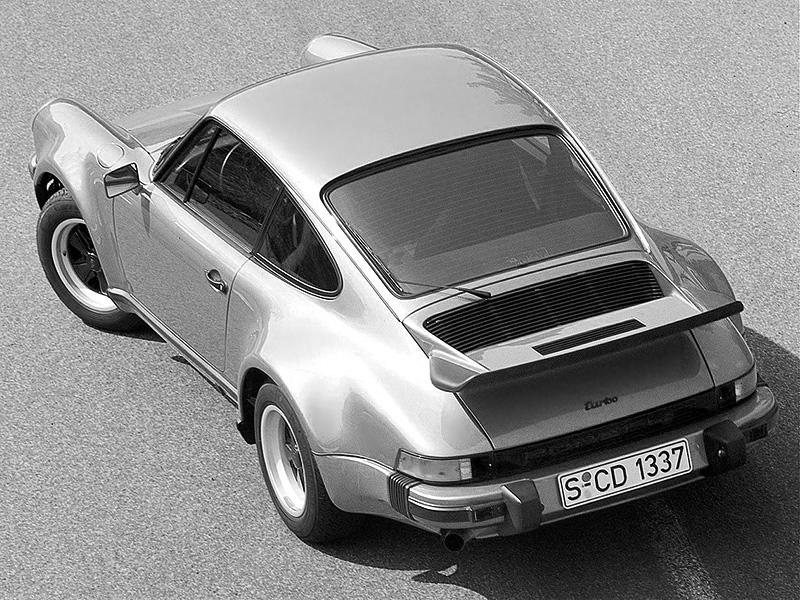

480000

In [28]:
green_image = Image.new('L', (width, height))
green_image.putdata(green)
display(green_image)
len(green)

## C++ code - apply pooling, and resurse pooling

This code is a port of the Python code from the preceding notebook.  
http://localhost:8888/notebooks/2_Py_Convolution.ipynb  
In the previous notebook, the Python version of this code took **216.143** seconds, to recurse **100** times while performing <i>mean</i> pooling.

![cpp](./imgs/cpp.png)

## Calling above C++ code from Python takes some wrangling

In [34]:
def CPP_recurse_pooling(mat, width, recurse_cnt, use_max=False):    
    height = (int)(len(mat) / width)
    # create pointer array
    ptr_param = pointer((ctypes.c_int * len(mat))(*mat))
    # create reference to C++ fucntion
    recurse_convolution = cdll.LoadLibrary('./cpp/cmake-build-debug/libconvolution.so').recurse_convolution
    # calculate array size after function call
    returned_height = height - recurse_cnt
    returned_width  = width - recurse_cnt
    returned_convolution_array_size = returned_height * returned_width
    # define return type of integer pointer array
    recurse_convolution.restype = ctypes.POINTER(ctypes.c_int * (returned_convolution_array_size))
    # conver boolean to int
    f=0
    if use_max:
       f=1 
    # actuall call to C++ code
    ptr_array_convolution = recurse_convolution(ptr_param, width, height, recurse_cnt, f)
    # convert int pointer array to Python list
    ret_convo = np.ctypeslib.as_array( ptr_array_convolution.contents ,shape=(1,)).astype(int).tolist()
    # return Python list of convolution pixels
    return ret_convo

## Call C++ pooling function

In [39]:
recurse_cnt = 1
convolution = CPP_recurse_pooling(mat, width, recurse_cnt, True)

## visualize convolution

466100

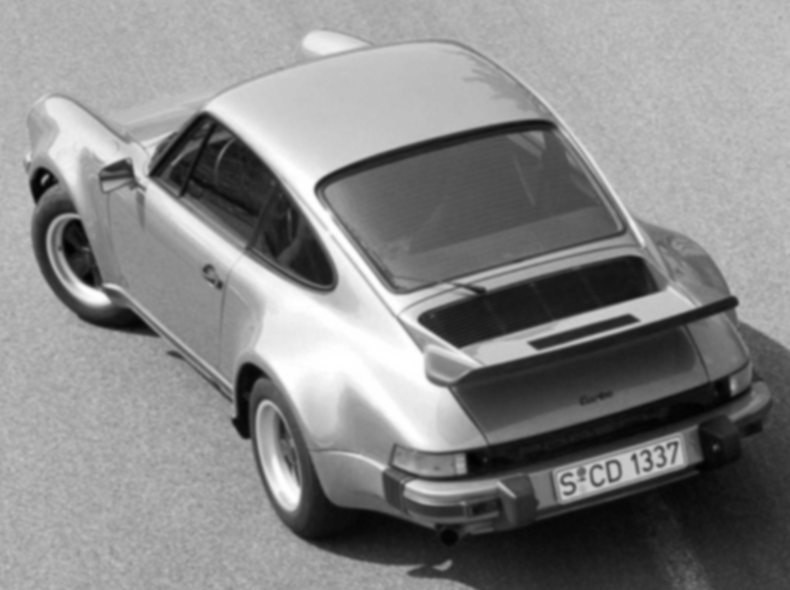

In [43]:
display(len(convolution))
display_channel(convolution, width - (recurse_cnt))

## another example, reduce by 10, use mean pooling

In [41]:
recurse_cnt = 10
convolution = CPP_recurse_pooling(mat, width, recurse_cnt, False)

## visualize convolution

466100

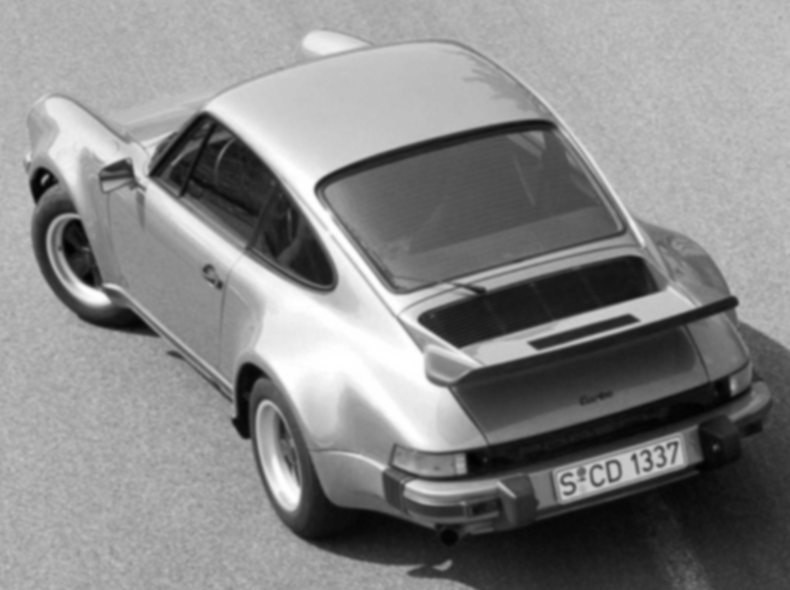

In [42]:
display(len(convolution))
display_channel(convolution, width - (recurse_cnt))